# Linear Regression Diagonostics

_The only thing we know about the future is that it will be different_ - Peter Drucker

Concepts:
- Linear regression diagnostics
- HAC robust standard errors
- Multicollinearity
- Residual analysis
- Consumer and Produced Prices Indices

References:
- White, Halbert (1980). "A Heteroskedasticity-Consistent Covariance Matrix Estimator and a Direct Test for Heteroskedasticity". Econometrica. 48 (4): 817–838.
- Newey, Whitney K., and Kenneth D. West. 1987. “A Simple, Positive Semi-Definite, Heteroskedasticity and Autocorrelation Consistent Covariance Matrix.” Econometrica 55: 703–8. 
- https://library.virginia.edu/data/articles/diagnostic-plots
- FRM Part I Exam Book Quantitative Analysis Ch 9


In [1]:
import numpy as np
import pandas as pd
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import patsy
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from finds.readers import Alfred
from finds.utils import plot_fitted, plot_leverage, plot_scale, plot_qq
from secret import credentials
VERBOSE = 0
# matplotlib qt

In [2]:
alf = Alfred(api_key=credentials['fred']['api_key'])

Retrieve monthly Consumer Price Index as the endogeneous variable, and Producer Price Index as the exogeneous. We use the monthly differences of logs of both series.  

In [3]:
# difference of logs of CPI and PPI monthly series from FRED
series_id, freq, start = 'CPIAUCSL', 'M', 0   #19740101
exog_id = 'WPSFD4131'

data = pd.concat([alf(s, start=start) for s in [series_id, exog_id]], axis=1)
data.index = pd.DatetimeIndex(data.index.astype(str))
data = np.log(data).diff().dropna()  # model the changes in logs of the series
DataFrame.from_dict({s: alf.header(s) for s in [series_id, exog_id]},
                    orient='index', columns=['Description'])

,Description
CPIAUCSL,Consumer Price Index for All Urban Consumers: ...
WPSFD4131,Producer Price Index by Commodity: Final Deman...


## Model assumptions

1. $E[y_i] = b_0 + b_1 x_{i1} + ... + b_k x_{ik}$. &
2. $\{x_{i1} ,...,x_{ik} \}$ are non-stochastic variables. & 
3. $Var(y_i) = \sigma^2$. &
4. $\{ y_i \}$ are independent random variables. &
5. $\{ y_i \}$ are normally distributed.  &

Under assumptions 1-4, the least squares regression estimator
  $b = (X' X)^{-1} X' y$ is an unbiased estimator of the parameter
  vector $b$;
- has variance-covariance matrix $Var(b) = \sigma^2 (X' X)^{-1}$,
- and standard error $b_j$ $se(b_j) = \sigma \sqrt{(X' X)^{-1}_{[j+1,j+1]}}$.
- Under assumptions 1-5, the least squares stimator is normally distributed.
  



In [4]:
# Run Linear Regression (with exog and 2 lags)
dmf = (f'{series_id} ~ {series_id}.shift(1) + {series_id}.shift(2) + {exog_id}.shift(1)')
model = smf.ols(formula=dmf, data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCSL   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     165.4
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           5.95e-78
Time:                        08:59:07   Log-Likelihood:                 2761.8
No. Observations:                 599   AIC:                            -5516.
Df Residuals:                     595   BIC:                            -5498.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0009      0

### Heteroskedasity and HAC robust errors

When the variances of residuals are not constant, than the variance of the coefficients is not given by the standard OLS estimate $\sigma^2 (X' X)^{-1}$. The coefficient estimates are consistent, but their covariance matrix is of the form 
$(X' X)^{-1}(X' \Omega X)(X' X)^{-1}$ where a number of choices have been proposed for the choice $\Omega$.  When estimated as the diagonal of squared residuals, this provides White's (1980) estimator, often referred to as the heteroskedasticity-consistent or sandwich estimator. Other estimators take into account the effect of leverage points in the design matrix.  

If the error terms are serially correlated, then statistical inference using the usual heteroskedasticity-robust standard errors can be misleading. Newy and West (1987) proposed 
the Heteroskedasticity and Autocorrelation Consistent (HAC) estimator which adjusts for serially correlated errors by applying a weighting scheme to estimates of $m-1$ autocorrelation coefficients. A rule of thumb for choosing the truncation parameter is $m = 0.75 T^{1/3}$, where the autocorrelation coefficients are weighted with $1 + 2 \sum_{j=1}^{m-1} \dfrac{m-j}{m} \hat{\rho_j}$


In [5]:

robust = model.get_robustcov_results(cov_type='HAC', use_t=None, maxlags=0)
print(robust.summary())

                            OLS Regression Results                            
Dep. Variable:               CPIAUCSL   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     111.5
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           2.75e-57
Time:                        08:59:07   Log-Likelihood:                 2761.8
No. Observations:                 599   AIC:                            -5516.
Df Residuals:                     595   BIC:                            -5498.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0009      0

### Multicollinearity and variance inflation factors

Multicollinearity or numerical scaling issues may cause the design matrix to have a high condition number.

The Variance Inflation Factor (VIF) measures the extent to which the variance of an estimated regression coefficient is increased due to multicollinearity in a multiple regression analysis. The VIF for each predictor variable $X_i$ is derived from the $R^2$ value obtained by regressing $X_i$ against all other predictor variables.

$$\mathrm{VIF_i} = \dfrac{1}{1-R^2_i}$$

One recommendation is that if VIF is greater than 5 or 10, then the explanatory
variable is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.



In [6]:
Y, X = patsy.dmatrices(dmf + ' - 1', data=data)  # exclude intercept term  
print("Variance Inflation Factors")
Series({X.design_info.column_names[i]: variance_inflation_factor(X, i)
        for i in range(X.shape[1])}, name='VIF').to_frame()

Variance Inflation Factors


,VIF
CPIAUCSL.shift(1),3.424302
CPIAUCSL.shift(2),3.408784
WPSFD4131.shift(1),2.283663


### Omitted variables

Omitting a variable with a non-zero coefficient in the true model generating the data has two effects. 

1.  The remaining variables absorb the effects of the omitted variable attributable to common variation. This changes the regression coefficients on the included variables so that they do not consistently estimate the effect of a change in the explanatory variable on the dependent variable. If the variables are highly correlated, then the bias is large.  But if the omitted variable is not correlated to the other variables, then those other coefficients can be estimated consistently.

2. The estimated residuals are larger in magnitude than the true shocks. This is because the residuals contain both the true shock and any effect of the omitted variable that cannot be captured by the included variable.

An extraneous (also known as a superfluous or irrelevant) variable is one that is included in the model but is not needed. This type of variable has a true coefficient of 0 and is consistently estimated to be 0 in large samples.  However, standard errors of the relevant variables grows as their correlation with the extraneous variables increases.

## Residual plots

Residual plots are standard methods used to detect deficiencies in a model specification. An ideal model would have residuals that are not systematically related to any of the included explanatory variables. Standardized residuals may alternatively be used so that the magnitude of deviation is more apparent. Both outliers and model specification problems can be detected in residual plots.

### Residuals vs fitted plot

The Residuals vs Fitted plot shows if residuals have non-linear patterns: the residual data points should be evenly spread around a flat fitted line. 



Residual Outliers


date,2005-09-30,2008-10-31,2008-11-30
outliers,0.00935,-0.011058,-0.015598


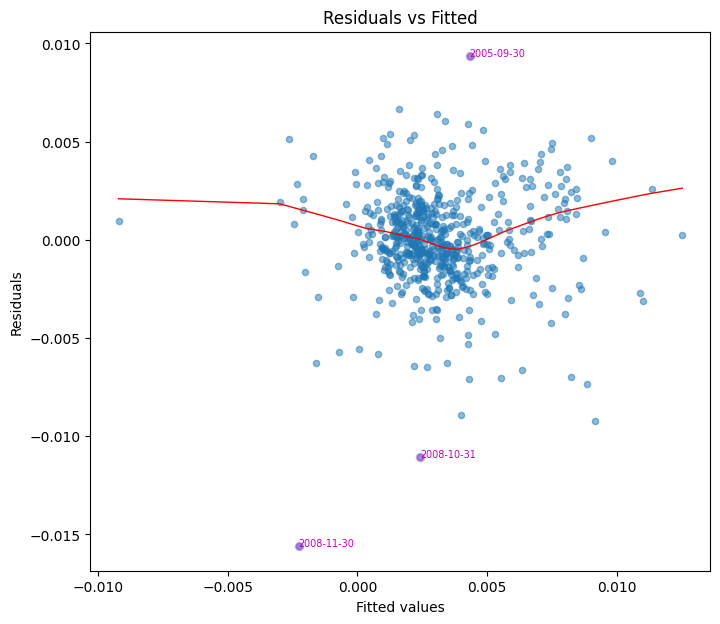

In [7]:
# Plot residuals and identify outliers
fig, ax = plt.subplots(clear=True, figsize=(8,7))
z = plot_fitted(fitted=model.fittedvalues,
                resid=model.resid,
                ax=ax)
print("Residual Outliers")
z.to_frame().T

### QQ plot of residuals

The Normal Q-Q plot shows if residuals are normally distributed: the standardized data points should lie along the 45-degree line representing the theoretical quantiles of the standard normal distribution.

__Outliers__, or data points that differ significantly from the others, may indicate some measurement error or anomaly, or that the population has a non-normal heavy-tailed distribution.


/home/terence/env3.11/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


,residuals,standardized
date,,
2008-11-30,-0.015598,-6.482161
2008-10-31,-0.011058,-4.595524
2022-07-31,-0.009212,-3.828462
2006-09-30,-0.008912,-3.703545
2005-10-31,-0.007328,-3.045586
2013-03-31,-0.007109,-2.954440
2008-08-31,-0.007021,-2.917872
1980-07-31,-0.007007,-2.911938
2005-09-30,0.009350,3.885717


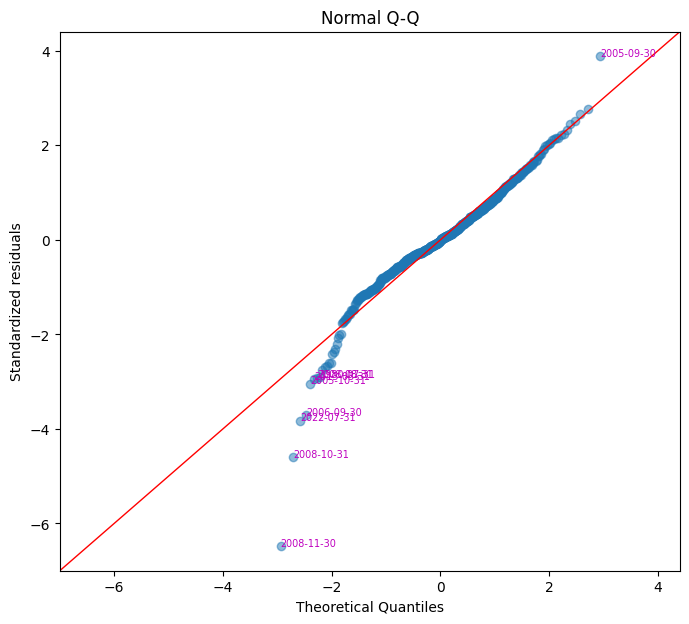

In [8]:
fig, ax = plt.subplots(clear=True, figsize=(8,7))
plot_qq(model.resid, ax=ax)

### Scale of residuals

The Scale-Location plot shows if residuals are spread equally
along the range of predictors, around a flat fitted line: it checks
the assumption of equal variance or homoscedasticity.


array([377, 414, 415])

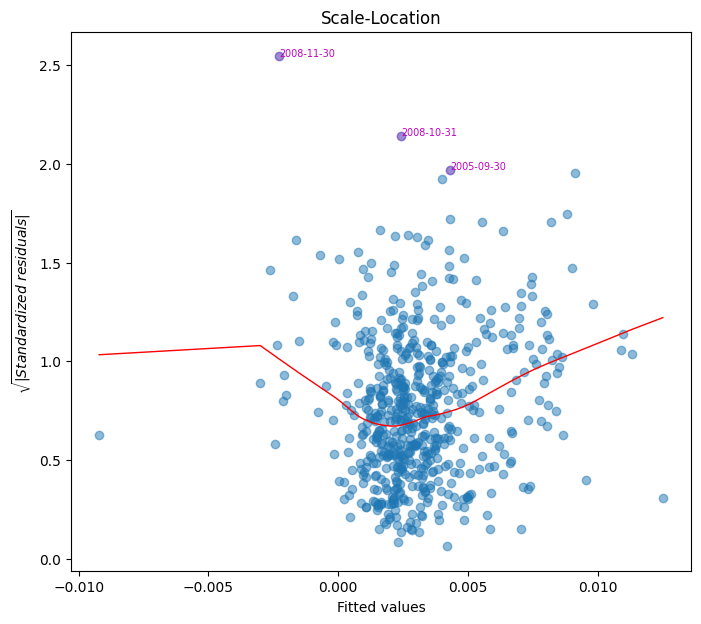

In [9]:
fig, ax = plt.subplots(clear=True, figsize=(8,7))
plot_scale(model.fittedvalues, model.resid, ax=ax)

### Leverage and influential points

The projection matrix from the least squares estimator $H = X(X^T)^{-1} X^T$ is also called
the __hat matrix__ in statistics, and the $i$-th diagonal element of $H$, given by
$h_{ii} = x_{i}^T (X^T)^{-1} x_{i}$, is the __leverage__ of the $i$-th observation.

Even though the data may have extreme leverage or outlier values, they
might not be influential on the regression fit.  __Cook's Distance__ can be expressed using the leverage and the squared internally studentized residual 
$$D_i = \frac{1}{p} t_i^2 \frac{h_{ii}}{1 - h_{ii}}$$

where 
- $p$ is the number of regression model parameters,   
- $t_i = \frac{\hat{\epsilon}_i}{\hat{\sigma} (1-h_{ii})}$, also known as the __studentized residual__, which accounts for the estimated residuals having unequal variances (even though the true errors have equal variance).
- and $\hat{\sigma} = \sqrt{\sum_{j=1}^n \hat{\epsilon}_j^2/n}$.
 
A threshold of $D_i > 1$ is often suggested to identify influential observations.
The Residuals vs Leverage plot helps us to find influential outliers.

,influential,cook's D,leverage
date,,,


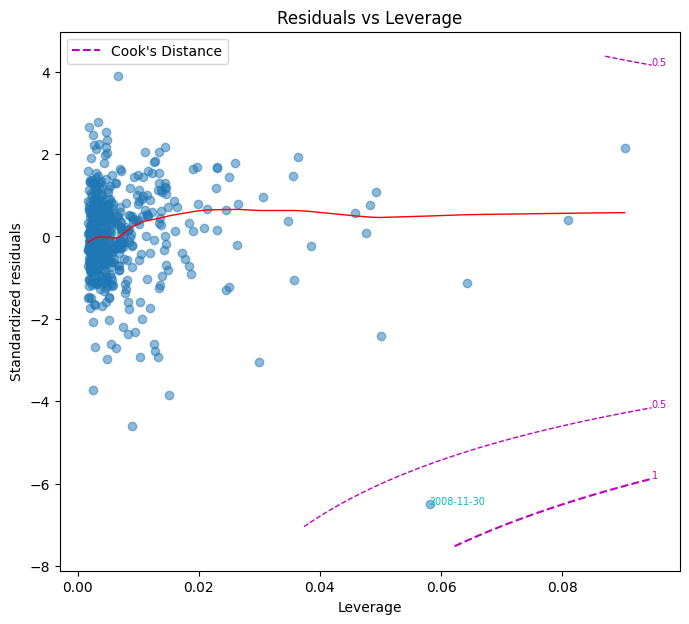

In [10]:
fig, ax = plt.subplots(clear=True, figsize=(8,7))
plot_leverage(model.resid, model.get_influence().hat_matrix_diag,
              model.get_influence().cooks_distance[0],
              ddof=len(model.params), ax=ax)